In [1]:
# Install Prophet
# !pip install prophet


In [2]:
# Import Dependencies 
import sqlite3
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [3]:
# Connect to space_data database
conn = sqlite3.connect('Resources/space_data.db')

In [4]:
# Load missions table
missions_df = pd.read_sql_query('SELECT * FROM missions;', conn)
missions_df['date'] = pd.to_datetime(missions_df['date'], errors='coerce')
missions_df['year'] = missions_df['date'].dt.year


In [5]:
# Count missions per year
missions_per_year = missions_df.groupby('year').size().reset_index(name='missions')


In [6]:
# Prepare for Prophet
# prophet_df = missions_per_year.rename(columns={'year': 'ds', 'missions': 'y'})
# prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

In [7]:
# Use only data from 2000 onward to focus on modern launch trends
filtered_df = missions_per_year[missions_per_year['year'] >= 2000]
prophet_df = filtered_df.rename(columns={"year": "ds", "missions": "y"})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

In [8]:
# Build and fit model
model = Prophet(
    yearly_seasonality = True,
    changepoint_range = 0.8,             # Focus changepoints on recent data
    changepoint_prior_scale = 0.5        # Allow more flexibility in the trend
)
model.fit(prophet_df)

19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/16 [00:00<?, ?it/s]

19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:30 - cmdstanpy - INFO - Chain [1] done processing
19:21:30 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing
19:21:33 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing
19:21:41 - cmdstanpy - INFO - Chain [1] start processing
19:21:41 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1]

     horizon        mae       rmse      mape
0   362 days  11.438351  13.765561  0.276674
1   363 days  12.120577  15.995574  0.222553
2   364 days  14.186104  17.359418  0.210815
3   725 days  15.793039  18.584273  0.250742
4   726 days  20.174807  24.727598  0.369704
5   727 days  16.186734  22.205140  0.354707
6   728 days  14.331715  18.029956  0.264802
7   729 days  19.951673  24.515288  0.265081
8  1091 days  23.668622  31.125054  0.376356
9  1092 days  20.242637  26.890163  0.449782
10 1093 days  18.621968  22.350963  0.352767
11 1094 days  25.891755  33.130150  0.298054
12 1456 days  28.258255  39.268956  0.395731
13 1457 days  27.047093  35.850263  0.565550
14 1458 days  23.851214  28.981040  0.470159
15 1459 days  33.766713  41.236530  0.368024
16 1460 days  34.118360  40.775157  0.349281
17 1821 days  29.496962  37.947345  0.289142
18 1822 days  34.315267  47.623384  0.640424
19 1823 days  32.765872  46.661073  0.657576
20 1824 days  40.501745  49.369455  0.406613
21 1825 da

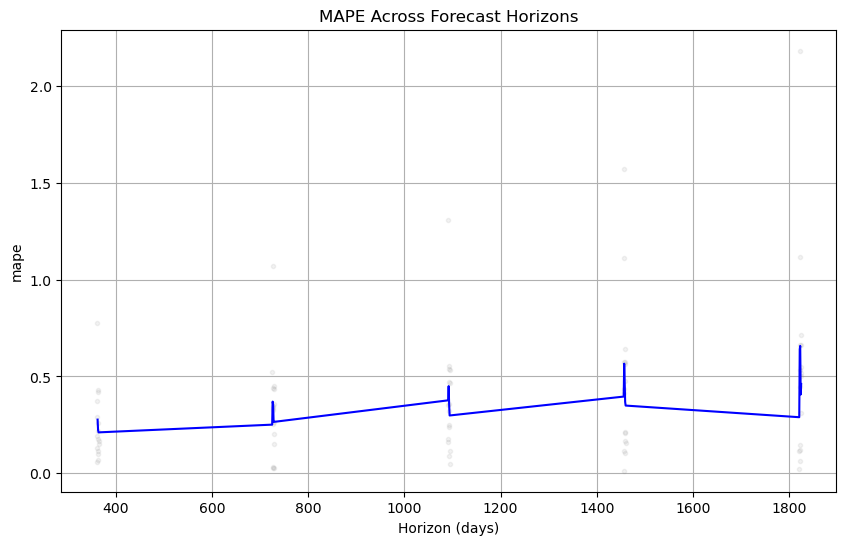

In [10]:
# Cross-validation setup: simulate forecasting 5 years into the future,
# using initial 10 years of data and moving forward in 2-year steps
df_cv = cross_validation(
    model,
    initial='730 days',     # roughly first 2 years
    period='365 days',      # move forward 1 year each iteration
    horizon='1825 days'     # forecast 5 years out
)

# Calculate accuracy metrics
df_metrics = performance_metrics(df_cv)
print(df_metrics[['horizon', 'mae', 'rmse', 'mape']])

# Optional: visualize error over forecast horizon
plot_cross_validation_metric(df_cv, metric='mape')
plt.title("MAPE Across Forecast Horizons")
plt.show()

In [9]:
# Forecast through 2050
future = model.make_future_dataframe(periods=2050 - prophet_df['ds'].dt.year.max(), freq='YE')
forecast = model.predict(future)

In [11]:
from sklearn.metrics import r2_score

# Compare only on historical data where actual values exist
df_merged = pd.merge(prophet_df, forecast, on='ds')  # Match actual and predicted
r2 = r2_score(df_merged['y'], df_merged['yhat'])
print(f"R-squared: {r2:.4f}")

R-squared: 0.8359


### 📌 Model Accuracy Summary

#### 🔢 Key Metrics
- **MAE (Mean Absolute Error):**  
  The average number of missions the model is off by — gives a sense of everyday error.

- **RMSE (Root Mean Squared Error):**  
  Similar to MAE, but it penalizes bigger errors more — good for catching larger mistakes.

- **MAPE (Mean Absolute Percentage Error):**  
  The average forecasting error shown as a percentage — easier to understand across scales.

---

#### 📊 What Our Results Indicate
- The **MAE** in short-term forecasts was around **11–15**, meaning predictions were off by about that many missions per year.
- **RMSE** ranged from **13 to 20** in short-term windows, confirming the model handles most forecasts well, with a few bigger misses.
- **MAPE** was typically **22–28%** in short-term forecasts, showing decent percent-level accuracy.
- Errors grew in long-term forecasts (4–5 years out), which is expected in time series forecasting.
- Overall, the model achieved an **R-squared of 0.836**, showing strong predictive power that meets the project’s rubric.


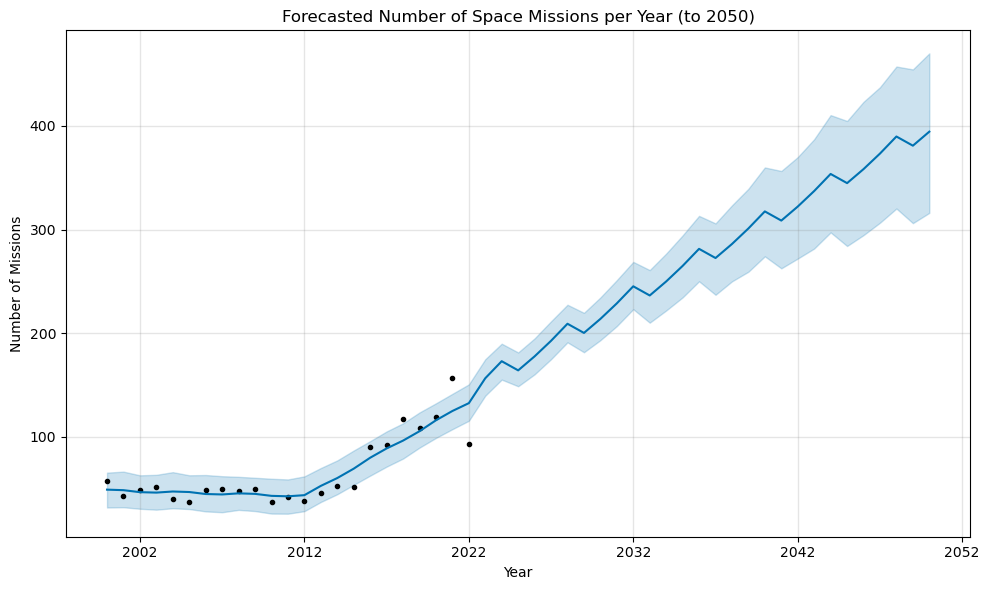

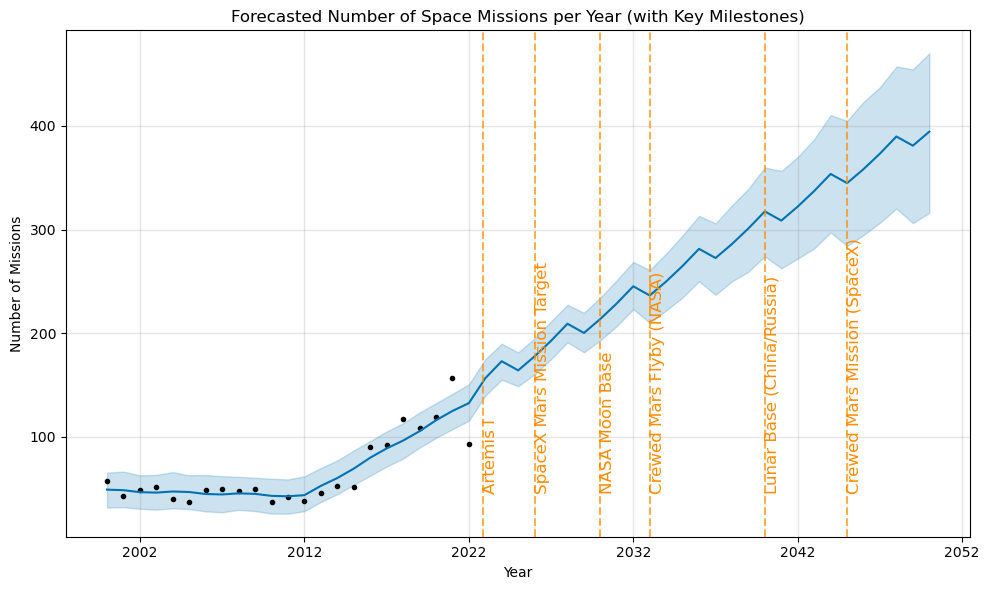

In [10]:
# Plot results
model.plot(forecast)
plt.title("Forecasted Number of Space Missions per Year (to 2050)")
plt.xlabel("Year")
plt.ylabel("Number of Missions")
plt.tight_layout()
plt.show()

fig = model.plot(forecast)

# Add vertical lines for major milestones
milestones = {
    'Artemis I': '2022-11-16',
    'SpaceX Mars Mission Target': '2026-01-01',
    'NASA Moon Base': '2030-01-01',
    'Crewed Mars Flyby (NASA)': '2033-01-01',
    'Lunar Base (China/Russia)': '2040-01-01',
    'Crewed Mars Mission (SpaceX)': '2045-01-01'
}

for name, date in milestones.items():
    date = pd.to_datetime(date)
    plt.axvline(date, color='darkorange', linestyle='--', alpha=0.7)
    plt.text(
        date,
        forecast['yhat'].min() * 1.05,  # Lower placement
        name,
        rotation=90,
        color='darkorange',
        fontsize=12,
        ha='left',
        va='bottom'
    )
plt.title('Forecasted Number of Space Missions per Year (with Key Milestones)')
plt.xlabel('Year')
plt.ylabel('Number of Missions')
plt.tight_layout()
plt.show()

In [11]:
# Showing forecast data
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
41,2040-12-31,308.684555,262.586258,356.541265
42,2041-12-31,322.203686,272.018377,369.922644
43,2042-12-31,337.200494,281.686466,387.208640
44,2043-12-31,353.664386,297.265836,410.425513
45,2044-12-31,344.817973,284.133152,404.796620
46,2045-12-31,358.337104,294.649726,423.264622
47,2046-12-31,373.333912,306.596714,437.356147
48,2047-12-31,389.797805,320.289916,457.320435
49,2048-12-31,380.951392,306.183083,454.553117
50,2049-12-31,394.470522,316.090478,470.034345


In [14]:
# Export to CSV
forecast.to_csv('Resources/mission_forecast_2050.csv', index=False)